In [35]:
import pennylane as qml
import numpy as np
from functools import partial
from math import sqrt, asin, log2

from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2

from matplotlib import pyplot as plt

In [2]:
def extract_probs(probs):
    """
    Returned dictionary is ordered by index.
    """
    num_qubits = int(log2(len(probs)))
    state_probs = {format(idx, f"0{num_qubits}b"): probs[idx] for idx in range(len(probs))}

    return state_probs

In [3]:
def bar_plot(state_probs):
    n_obs = len(state_probs)
    n_qubits = int(log2(n_obs))
    x_pos = list(range(n_obs))
    plt.bar(x_pos, list(state_probs.values()), color='mediumseagreen')
    plt.xticks(x_pos, list(state_probs.keys()), rotation=45)
    plt.xlabel("State")
    plt.ylabel("Probability")
    plt.title(f"Quantum Galton Board Distribution (n = {n_qubits})")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [4]:
def random_flip(p_flip, flip_wire):
    if np.random.rand() < p_flip:
        gate_choice = np.random.choice([qml.PauliX])
        gate_choice(wires=flip_wire)

In [5]:
def random_angle(p_rand, phi, prec):
    if np.random.rand() < p_rand:
        phi = phi + prec*np.random.rand()

    return phi

In [6]:
def qml_random_flip(p_flip, flip_wire):
    flip_choice = np.random.choice([qml.BitFlip, qml.PhaseFlip])
    flip_choice(p_flip, wires=flip_wire)

# Ideal circuit

## Noiseless QGB for n=4

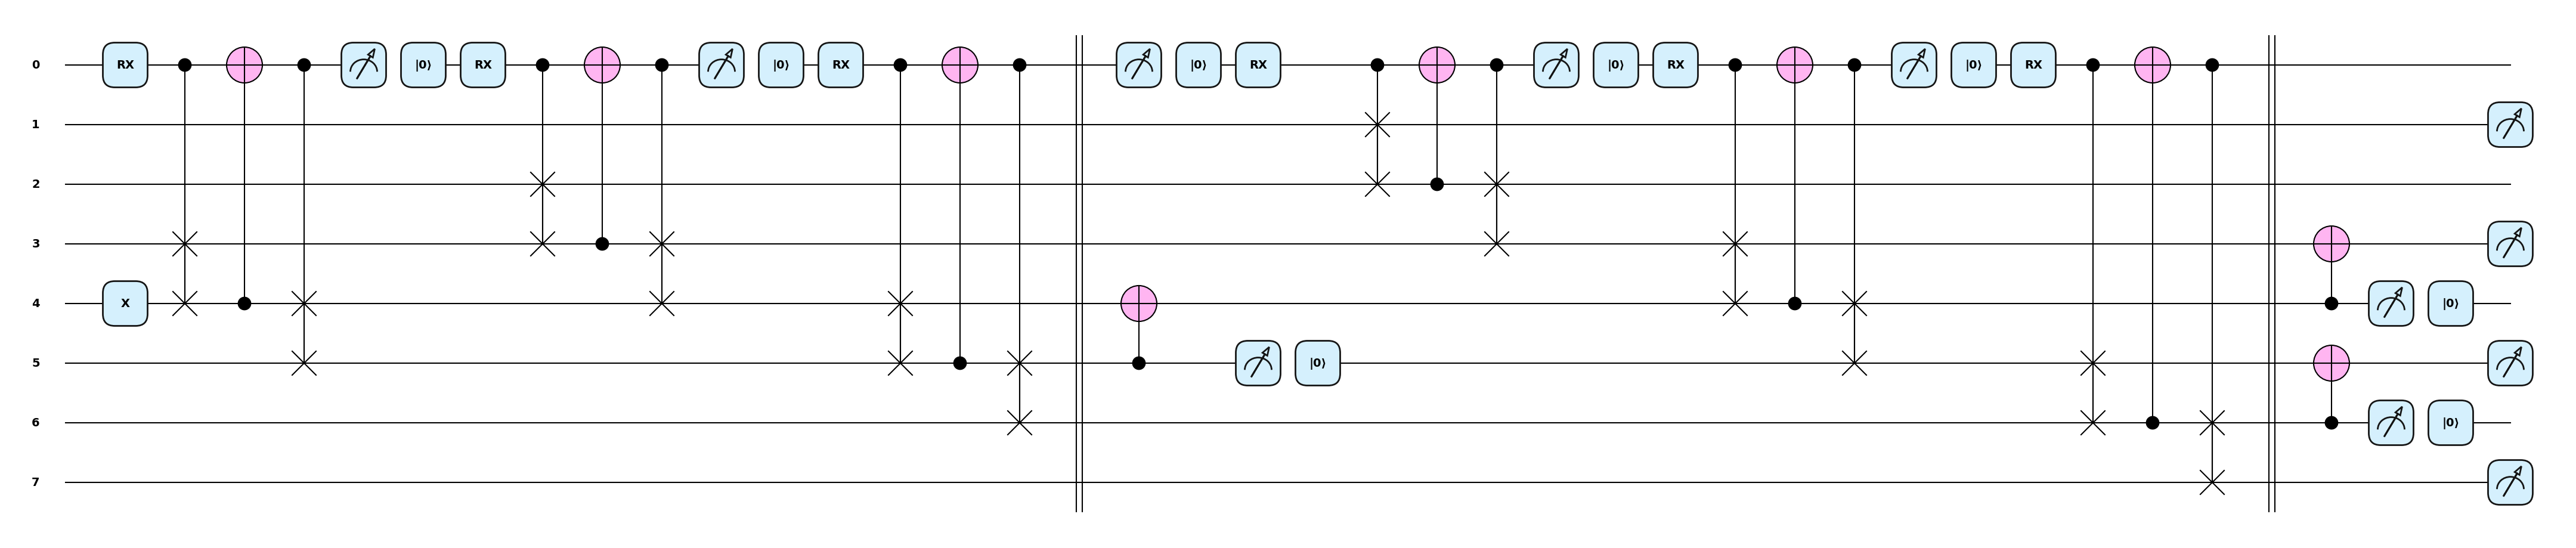

In [9]:
n = 4
dev = qml.device("lightning.qubit", wires=2*n, shots=1000)

phi = 2*asin(sqrt(0.5))

@qml.qnode(dev)
def ideal_circuit():
    # First row
    qml.RX(phi, wires=0)
    qml.PauliX(wires=4)
    qml.CSWAP(wires=[0,4,3])
    qml.CNOT(wires=[4,0])
    qml.CSWAP(wires=[0,5,4])
    
    # Reset control wire
    qml.measure(wires=0, reset=True)

    # Second row
    qml.RX(phi, wires=0)
    qml.CSWAP(wires=[0, 3, 2])
    qml.CNOT(wires=[3, 0])
    qml.CSWAP(wires=[0, 4, 3])
    
    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)
    
    qml.CSWAP(wires=[0, 4, 5])
    qml.CNOT(wires=[5, 0])
    qml.CSWAP(wires=[0, 5, 6])

    qml.Barrier()
    qml.CNOT(wires=[5, 4])
    qml.measure(wires=5, reset=True)

    # Third row
    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)
    qml.CSWAP(wires=[0, 2, 1])
    qml.CNOT(wires=[2, 0])
    qml.CSWAP(wires=[0, 3, 2])

    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)

    qml.CSWAP(wires=[0, 4, 3])
    qml.CNOT(wires=[4, 0])
    qml.CSWAP(wires=[0, 5, 4])

    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)
    
    qml.CSWAP(wires=[0, 6, 5])
    qml.CNOT(wires=[6, 0])
    qml.CSWAP(wires=[0, 7, 6])

    qml.Barrier()
    qml.CNOT(wires=[4, 3])
    qml.measure(wires=4, reset=True)

    qml.CNOT(wires=[6, 5])
    qml.measure(wires=6, reset=True)
    
    return qml.probs(wires=[1,3,5,7])

qml.draw_mpl(ideal_circuit, style="pennylane")();

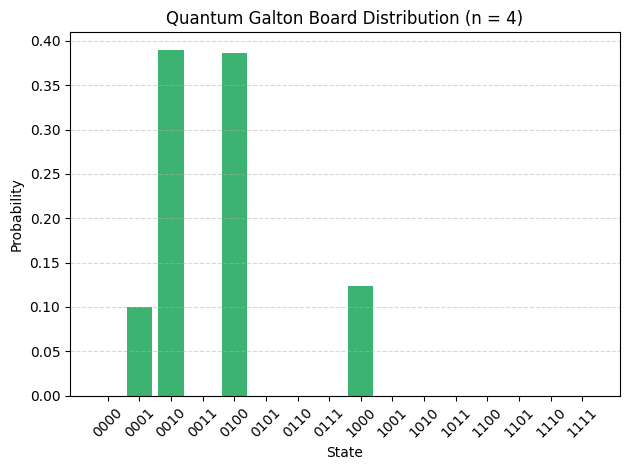

In [10]:
# Run simulation
probs = ideal_circuit()

# Extract probabilities
state_probs = extract_probs(probs)

# Plot
bar_plot(state_probs)

# Noise through randomization

Devices that natively support noise, like "default.mixed" and "qiskit.aer", require to manually add the ancilla qubits that are used under the hood for the qubit resets during the QNode creation, even when one-shot is selected for mid-circuit measurement. To keep using lightning.qubit as the device, we could manually create noise through bit- and phase-flips, and parameter randomization.

# Noisy QGB for n=4

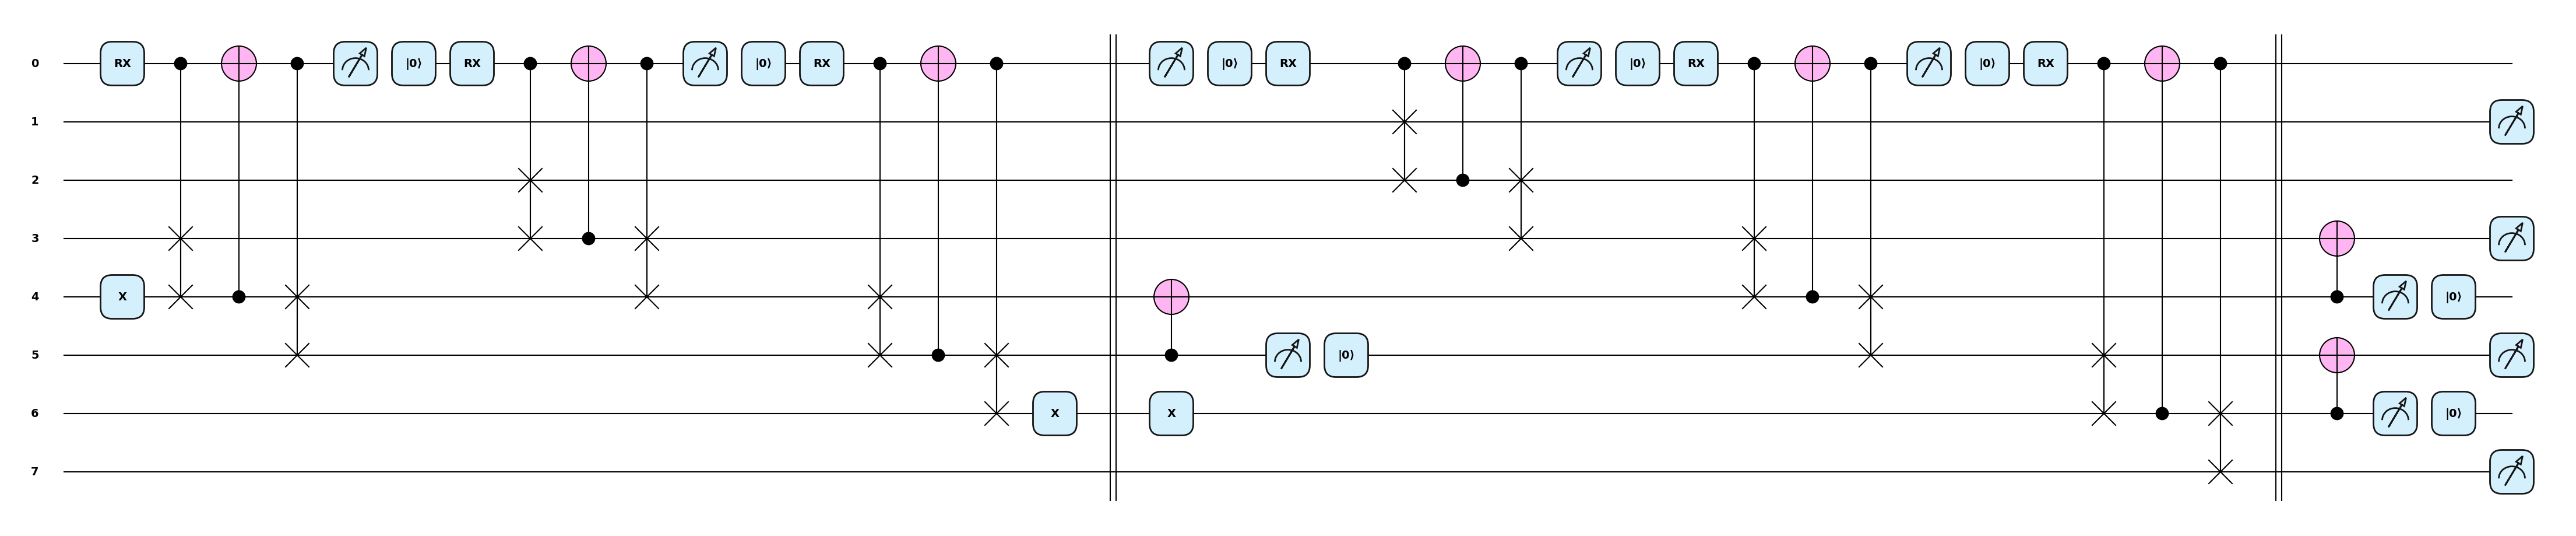

In [9]:
# Randomly introduce noise on the rotation angles
n = 4
n_wires = 2*n
dev = qml.device("lightning.qubit", wires=n_wires, shots=1000)

phi = 2*asin(sqrt(0.5))

@qml.qnode(dev)
def noisy_circuit():
    # First row
    qml.RX(random_angle(0.2, phi, 2), wires=0)
    qml.PauliX(wires=4)
    qml.CSWAP(wires=[0,4,3])
    qml.CNOT(wires=[4,0])
    qml.CSWAP(wires=[0,5,4])

    random_flip(0.2, np.random.randint(n_wires, size=1))
    
    # Reset control wire
    qml.measure(wires=0, reset=True)

    random_flip(0.2, np.random.randint(n_wires, size=1))

    # Second row
    qml.RX(random_angle(0.2, phi, 2), wires=0)
    qml.CSWAP(wires=[0, 3, 2])
    qml.CNOT(wires=[3, 0])
    qml.CSWAP(wires=[0, 4, 3])

    random_flip(0.2, np.random.randint(n_wires, size=1))
    
    qml.measure(wires=0, reset=True)
    qml.RX(random_angle(0.2, phi, 2), wires=0)

    random_flip(0.2, np.random.randint(n_wires, size=1))
    
    qml.CSWAP(wires=[0, 4, 5])
    qml.CNOT(wires=[5, 0])
    qml.CSWAP(wires=[0, 5, 6])

    random_flip(0.2, np.random.randint(n_wires, size=1))

    qml.Barrier()
    qml.CNOT(wires=[5, 4])
    qml.measure(wires=5, reset=True)

    random_flip(0.2, np.random.randint(n_wires, size=1))

    # Third row
    qml.measure(wires=0, reset=True)
    qml.RX(random_angle(0.2, phi, 2), wires=0)
    qml.CSWAP(wires=[0, 2, 1])
    qml.CNOT(wires=[2, 0])
    qml.CSWAP(wires=[0, 3, 2])

    random_flip(0.2, np.random.randint(n_wires, size=1))

    qml.measure(wires=0, reset=True)
    qml.RX(random_angle(0.2, phi, 2), wires=0)

    random_flip(0.2, np.random.randint(n_wires, size=1))

    qml.CSWAP(wires=[0, 4, 3])
    qml.CNOT(wires=[4, 0])
    qml.CSWAP(wires=[0, 5, 4])

    random_flip(0.2, np.random.randint(n_wires, size=1))

    qml.measure(wires=0, reset=True)
    qml.RX(random_angle(0.2, phi, 2), wires=0)

    random_flip(0.2, np.random.randint(n_wires, size=1))
    
    qml.CSWAP(wires=[0, 6, 5])
    qml.CNOT(wires=[6, 0])
    qml.CSWAP(wires=[0, 7, 6])

    random_flip(0.2, np.random.randint(n_wires, size=1))

    qml.Barrier()
    qml.CNOT(wires=[4, 3])
    qml.measure(wires=4, reset=True)

    random_flip(0.2, np.random.randint(n_wires, size=1))

    qml.CNOT(wires=[6, 5])
    qml.measure(wires=6, reset=True)

    random_flip(0.2, np.random.randint(n_wires, size=1))
    
    return qml.probs(wires=[1,3,5, 7])

qml.draw_mpl(noisy_circuit, style="pennylane")(); #draws circuit

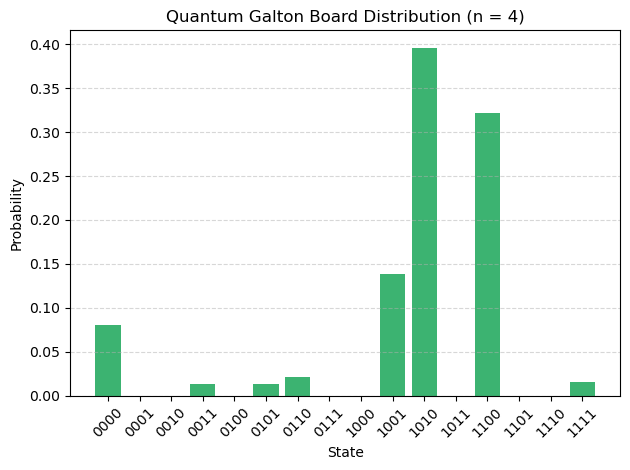

In [10]:
# Run simulation
probs = noisy_circuit()

# Extract probabilities
state_probs = extract_probs(probs)

# Plot
bar_plot(state_probs)

# Noise through noisy channels

Now we compare with noisy circuits built using Pennylane's built-in functionality. We are not using classical randomization of parameters here. Unfortunately, with the default.mixed device, the simulation uses too much memory for n=4 which gets the processed killed. We can run a circuit with 3 levels.

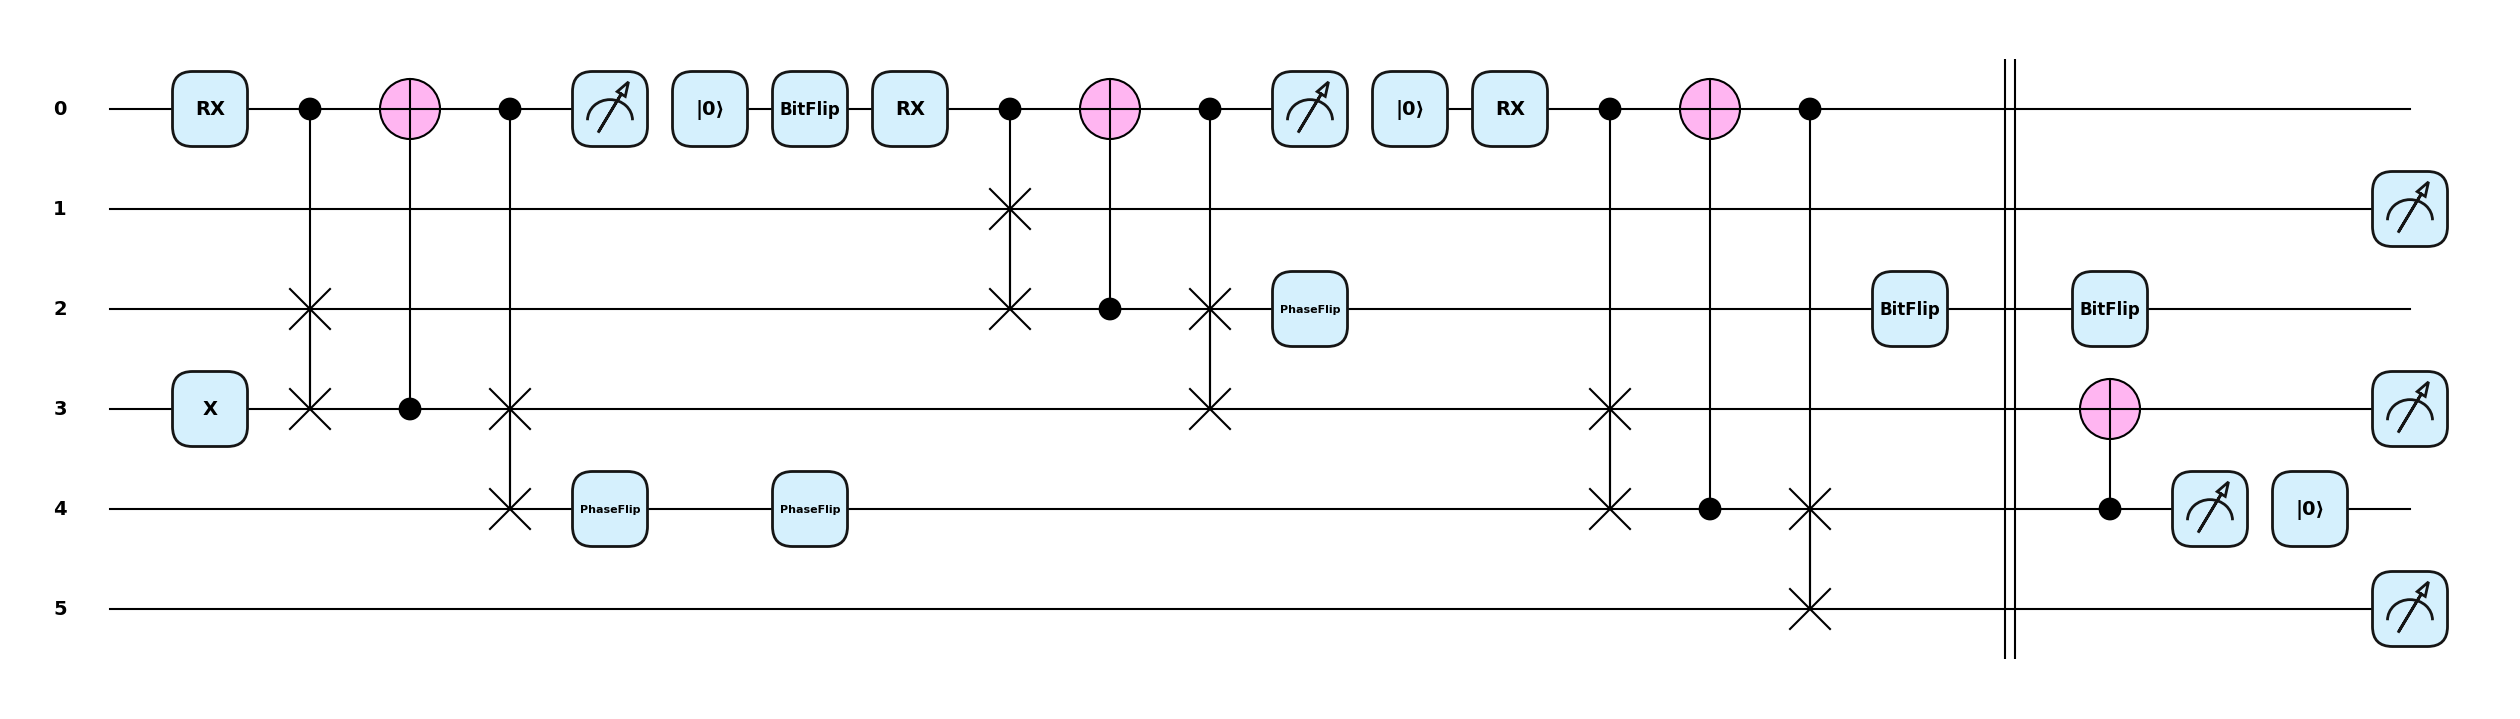

In [18]:
n = 3
n_wires = 2*n
num_mcm = 3  # Number of mid-circuit measurements
dev = qml.device("default.mixed", wires=n_wires + num_mcm, shots=10)

phi = 2*asin(sqrt(0.5))

@qml.qnode(dev)
def noisy_circuit2():
    # First row
    qml.RX(phi, wires=0)
    qml.PauliX(wires=3)
    qml.CSWAP(wires=[0,3,2])
    qml.CNOT(wires=[3,0])
    qml.CSWAP(wires=[0,4,3])

    qml_random_flip(0.2, np.random.randint(n_wires))
    
    # Reset control wire
    qml.measure(wires=0, reset=True)

    qml_random_flip(0.2, np.random.randint(n_wires))

    # Second row
    qml.RX(phi, wires=0)
    qml.CSWAP(wires=[0, 2, 1])
    qml.CNOT(wires=[2, 0])
    qml.CSWAP(wires=[0, 3, 2])

    qml_random_flip(0.2, np.random.randint(n_wires))
    
    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)

    qml_random_flip(0.2, np.random.randint(n_wires))
    
    qml.CSWAP(wires=[0, 3, 4])
    qml.CNOT(wires=[4, 0])
    qml.CSWAP(wires=[0, 4, 5])

    qml_random_flip(0.2, np.random.randint(n_wires))

    qml.Barrier()
    qml.CNOT(wires=[4, 3])
    qml.measure(wires=4, reset=True)

    qml_random_flip(0.2, np.random.randint(n_wires))
    
    return qml.probs(wires=[1,3,5])

qml.draw_mpl(noisy_circuit2, style="pennylane")(); #draws circuit

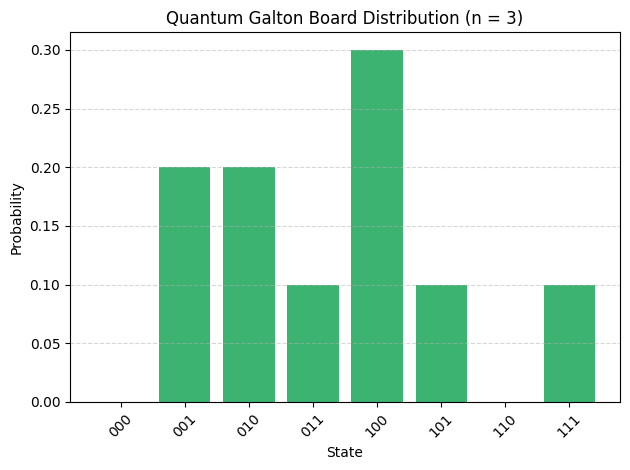

In [19]:
# Run simulation
probs = noisy_circuit2()

# Extract probabilities
state_probs = extract_probs(probs)

# Plot
bar_plot(state_probs)

# Noise models from Qiskit

In [47]:
backend = GenericBackendV2(num_qubits=n_wires, seed=42)
qk_noise_model = NoiseModel.from_backend(backend)
pl_noise_model = qml.from_qiskit_noise(qk_noise_model)

dev = qml.device("qiskit.aer", wires=2, shots=1000)

@partial(qml.transforms.add_noise, noise_model=pl_noise_model)
@qml.qnode(dev)
def cc():
    qml.PauliX(wires=1)
    return qml.probs(wires=[0,1])

cc()

/project/PERCUSA_1516/tmp/.venv/lib/python3.11/site-packages/pennylane_qiskit/noise_models.py:135: UserWarning: Readout errors are not supported currently and will be skipped.
  warn("Readout errors are not supported currently and will be skipped.")


KeyError: 'QubitChannel'

/project/PERCUSA_1516/tmp/.venv/lib/python3.11/site-packages/pennylane_qiskit/noise_models.py:135: UserWarning: Readout errors are not supported currently and will be skipped.
  warn("Readout errors are not supported currently and will be skipped.")


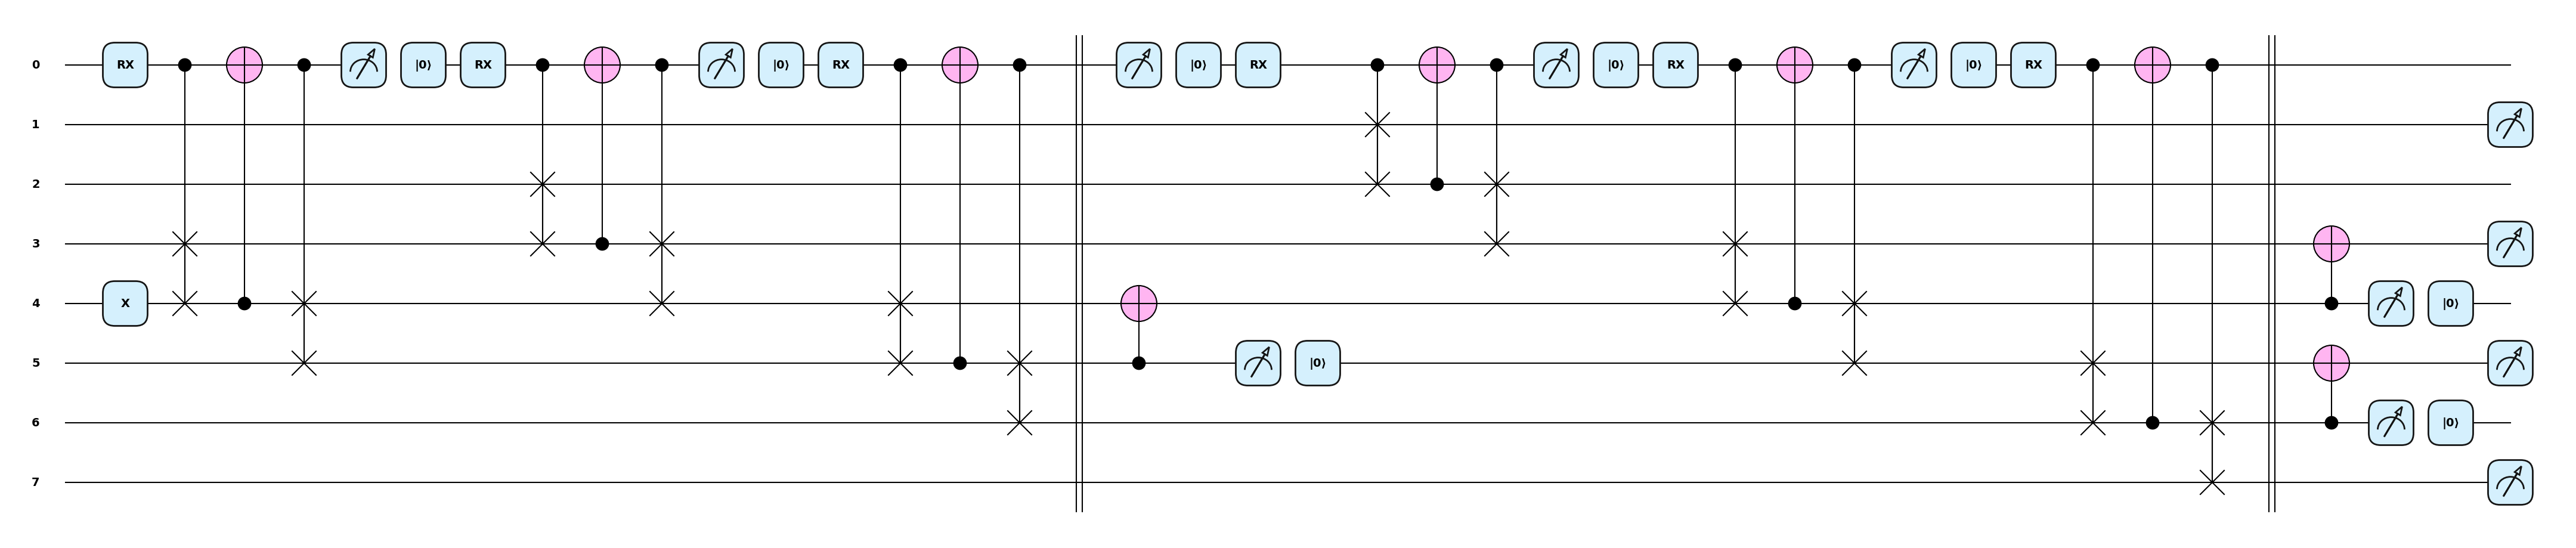

In [50]:
n = 4
n_wires = 2*n
n_mcm = 8  # Number of mid-circuit measurements

backend = GenericBackendV2(num_qubits=n_wires, seed=42)
qk_noise_model = NoiseModel.from_backend(backend)
pl_noise_model = qml.from_qiskit_noise(qk_noise_model)

dev = qml.device("qiskit.aer", wires=n_wires + n_mcm, shots=1000)

phi = 2*asin(sqrt(0.5))

@partial(qml.transforms.add_noise, noise_model=pl_noise_model)
@qml.qnode(dev)
def qiskit_circuit():
    # First row
    qml.RX(phi, wires=0)
    qml.PauliX(wires=4)
    qml.CSWAP(wires=[0,4,3])
    qml.CNOT(wires=[4,0])
    qml.CSWAP(wires=[0,5,4])
    
    # Reset control wire
    qml.measure(wires=0, reset=True)

    # Second row
    qml.RX(phi, wires=0)
    qml.CSWAP(wires=[0, 3, 2])
    qml.CNOT(wires=[3, 0])
    qml.CSWAP(wires=[0, 4, 3])
    
    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)
    
    qml.CSWAP(wires=[0, 4, 5])
    qml.CNOT(wires=[5, 0])
    qml.CSWAP(wires=[0, 5, 6])

    qml.Barrier()
    qml.CNOT(wires=[5, 4])
    qml.measure(wires=5, reset=True)

    # Third row
    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)
    qml.CSWAP(wires=[0, 2, 1])
    qml.CNOT(wires=[2, 0])
    qml.CSWAP(wires=[0, 3, 2])

    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)

    qml.CSWAP(wires=[0, 4, 3])
    qml.CNOT(wires=[4, 0])
    qml.CSWAP(wires=[0, 5, 4])

    qml.measure(wires=0, reset=True)
    qml.RX(phi, wires=0)
    
    qml.CSWAP(wires=[0, 6, 5])
    qml.CNOT(wires=[6, 0])
    qml.CSWAP(wires=[0, 7, 6])

    qml.Barrier()
    qml.CNOT(wires=[4, 3])
    qml.measure(wires=4, reset=True)

    qml.CNOT(wires=[6, 5])
    qml.measure(wires=6, reset=True)
    
    return qml.probs(wires=[1,3,5,7])

qml.draw_mpl(ideal_circuit, style="pennylane")();

In [51]:
# Run simulation
probs = qiskit_circuit()

# Extract probabilities
state_probs = extract_probs(probs)

# Plot
bar_plot(state_probs)

KeyError: 'QubitChannel'